In [1]:
# download links

%reload_ext autoreload
#%autoreload 2
from lib import utils

show_name = "maischberger-ard"
links = utils.download_links_old(show_name)

https://www.fernsehserien.de/maischberger-ard/sendetermine
https://www.fernsehserien.de/maischberger-ard/sendetermine/-2
https://www.fernsehserien.de/maischberger-ard/sendetermine/-3
LINK ERROR


In [ ]:
# download html for links

j_html = utils.download_html_from_links(show_name, links, skip_available_files = True)

In [1]:
# extract information from html

from lib import utils

l_show_name= ["anne-will", "hart-aber-fair", "maischberger-ard", "markus-lanz", "maybrit-illner"]

html = {}
for show_name in l_show_name:
    html[show_name] = utils.read_html_to_json(show_name)
    episoden = utils.extract_json_from_html(show_name, html[show_name])


100%|██████████| 448/448 [00:00<00:00, 7990.99it/s]


In [1]:
# write episodes to db

%reload_ext autoreload
#%autoreload 2
from lib import utils
import json
l_show_name= ["anne-will", "hart-aber-fair", "maischberger-ard", "markus-lanz", "maybrit-illner"]
#l_show_name= ["markus-lanz"]

episoden = []
for show_name in l_show_name:
    
    episoden.append(utils.read_episoden_to_json(show_name))

episoden = {k:v for element in episoden for k,v in element.items()}
df = utils.episoden_to_df(episoden)
utils.write_df_to_db("SENDUNGEN", df, constr = r"C:\Users\oliver.koehn\Documents\talkshowsAuswerten\private\database\medien.db")

1

In [2]:
# write guests to db

from lib import utils
import json
import pandas as pd


j_gaeste = {}
liste_parteien = ["SPD", "Grüne", "FDP", "CDU", "CSU", "AFD", "Linke"]

for e in episoden:
    for g in episoden[e]["gaeste"]:
        if not(g["name"] in j_gaeste):
            j_gaeste[g["name"]] = {}
            j_gaeste[g["name"]]["beschreibung"] = []
            j_gaeste[g["name"]]["partei"] = []
        j_gaeste[g["name"]]["beschreibung"].append(g["beschreibung"])
        j_gaeste[g["name"]]["beschreibung"] = list(set(j_gaeste[g["name"]]["beschreibung"]))
        partei = []
        for partei in liste_parteien:
            if partei.lower() in g["beschreibung"].lower():
                j_gaeste[g["name"]]["partei"].append(partei)
                j_gaeste[g["name"]]["partei"] = list(set(j_gaeste[g["name"]]["partei"]))

l = []
for e in j_gaeste:
    j_dummy = {}
    j_dummy["name"] = e
    j_dummy["beschreibung"] = ",".join(j_gaeste[e]["beschreibung"])
    j_dummy["partei"] = ",".join(j_gaeste[e]["partei"])
    l.append(j_dummy.copy())
utils.write_df_to_db("Gaeste", pd.DataFrame.from_records(l), constr = r"C:\Users\oliver.koehn\Documents\talkshowsAuswerten\private\database\medien.db")

1

2011
2012
2013
2023


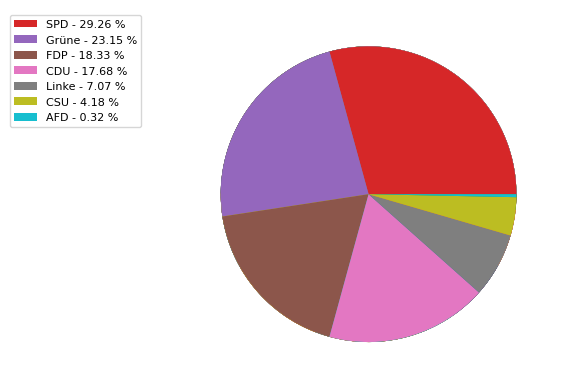

In [4]:
# evaluation

import pandas as pd
import datetime
from sqlite3 import connect
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


sql_template = """select partei, count(*) as c
from sendungen
inner join gaeste on 1 = 1
and gaeste.name = sendungen.name
where 1 = 1
and datum >= 'DUMMYSTART'
and datum <= 'DUMMYEND'
and length(partei) > 1
and instr(partei, ',') = 0
group by partei
order by 2 desc
;"""

d = {}
for y in range(2010,2024):
    start_date = datetime.datetime(y, 1, 1)
    end_date = datetime.datetime(y+1, 5, 17)
    sql = sql_template.replace("DUMMYSTART",start_date.strftime("%Y-%m-%d")).replace("DUMMYEND",end_date.strftime("%Y-%m-%d"))
    df = pd.read_sql(sql, connect(r"C:\Users\oliver.koehn\Documents\talkshowsAuswerten\private\database\medien.db"))

    if len(df) == 0:
        print(y)
        continue
    labels = df["partei"].to_list()
    c = df["c"].to_list()
    c = [100*e/sum(c) for e in c]

    for partei, partei_count in zip(labels, c):
        if not partei in d:
            d[partei] = {}
            d[partei]["t"] = []
            d[partei]["c"] = []
        d[partei]["t"].append(y)
        d[partei]["c"].append(partei_count)



    patches, texts = plt.pie(c)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, c)]
    plt.legend(patches, labels, bbox_to_anchor=(-0.1, 1.)
    #, loc = 'lower right'
    ,           fontsize=8)
    plt.savefig('out/plots/'+str(y) + '.pdf', bbox_inches = "tight")

